<a href="https://colab.research.google.com/github/chad-fisher/CRWA-Regional-Tree-Planting-and-Protection-Plan/blob/main/CodeNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx

In [2]:
cd "C:\Users\chadl\OneDrive\Desktop\CRWA Project"

C:\Users\chadl\OneDrive\Desktop\CRWA Project


<Axes: >

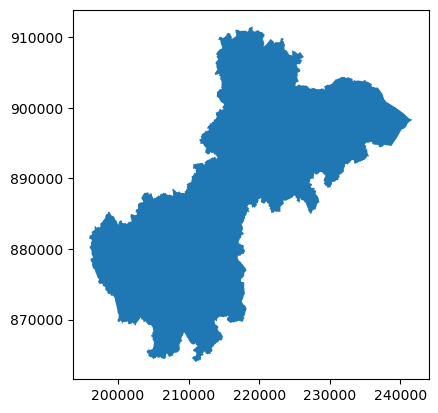

In [10]:
#Extracting Charles River Watershed Boundary
CRW_ = gpd.read_file("Raw_Data\watshd\watshdp1.shp")
CRW = CRW_[CRW_.NAME=="CHARLES"]
CRW.plot()

In [13]:
Ag_soils = gpd.clip(gpd.read_file("Raw_Data\Soils_MassGIS_SHP\SOILS_POLY_PRIMEFARMLAND.shp",mask=CRW),CRW)

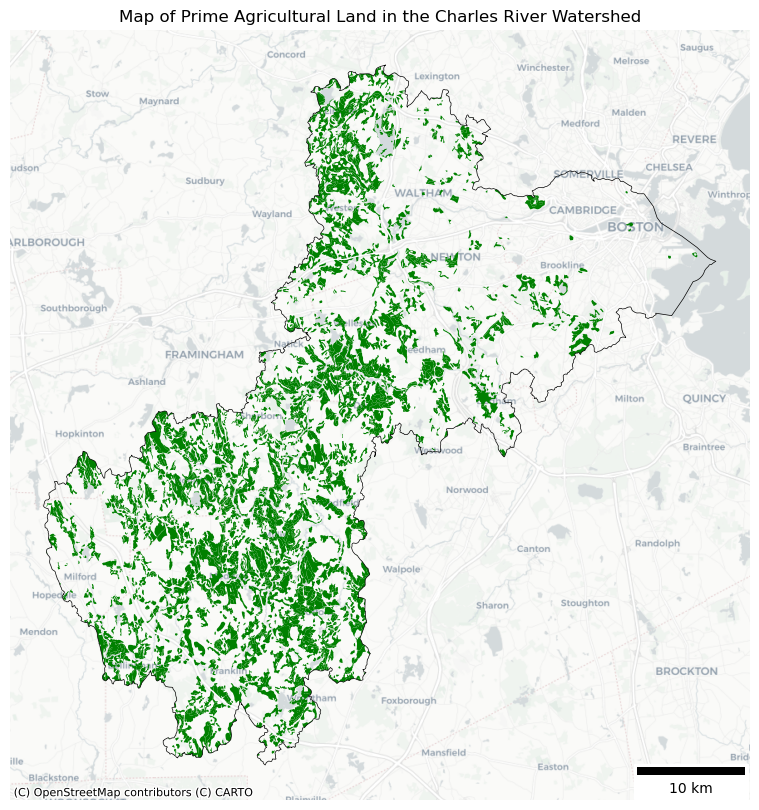

In [51]:
ax = Ag_soils.to_crs(epsg=3857).plot(figsize=(10,10),color='green')
CRW.to_crs(epsg=3857).boundary.plot(ax=ax, color='black',linewidth=0.5)
plt.title("Map of Prime Agricultural Land in the Charles River Watershed")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig('AgLandCRW.png')

In [15]:
Soils = gpd.clip(gpd.read_file("Raw_Data\Soils_MassGIS_SHP\SOILS_MUPOLYGON_TOP20.shp",mask=CRW),CRW)

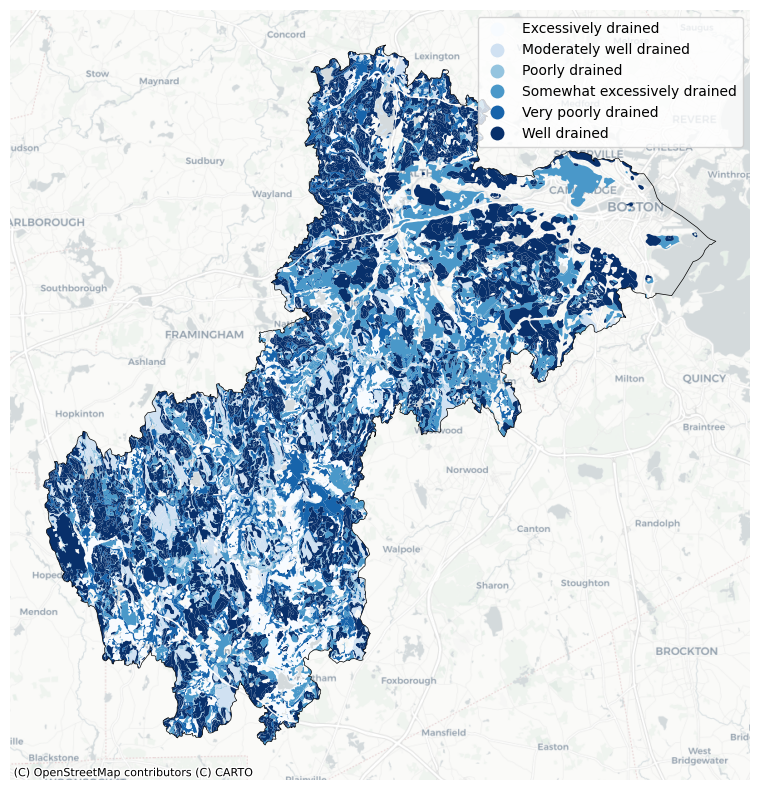

In [41]:
ax=Soils.to_crs(epsg=3857).plot(column="DRAINCLASS",legend=True,figsize=(10,10),cmap='Blues')
CRW.to_crs(epsg=3857).boundary.plot(ax=ax, color='black',linewidth=0.5)
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()